<a href="https://colab.research.google.com/github/varun-beep/Computer_VisionLab/blob/main/Shape_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

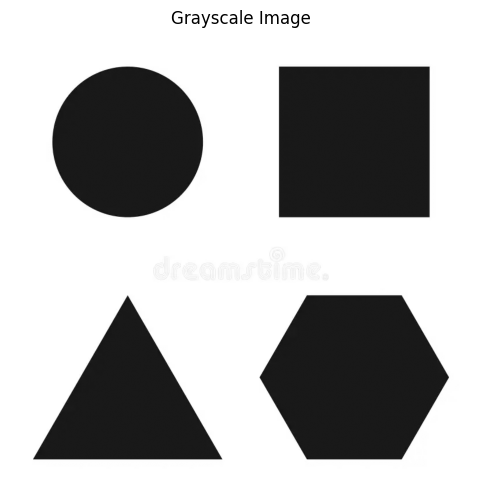

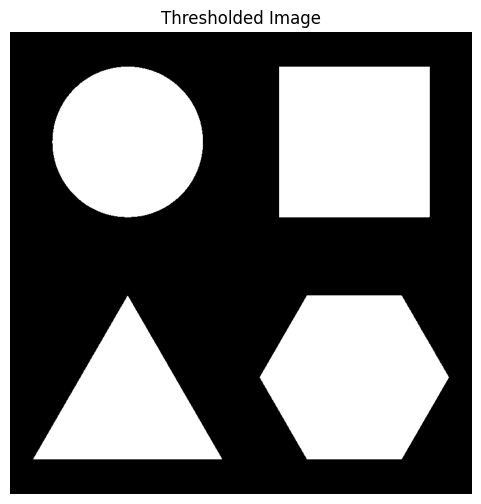

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title, cmap=None):
    plt.figure(figsize=(6, 6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load and preprocess image
img = cv2.imread("/content/basic-geometric-shapes-circle-square-triangle-black-white-vector-minimalistic-design-eps-349223993.jpg.webp")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
show_image(gray, "Grayscale Image", cmap='gray')
show_image(thresh, "Thresholded Image", cmap='gray')

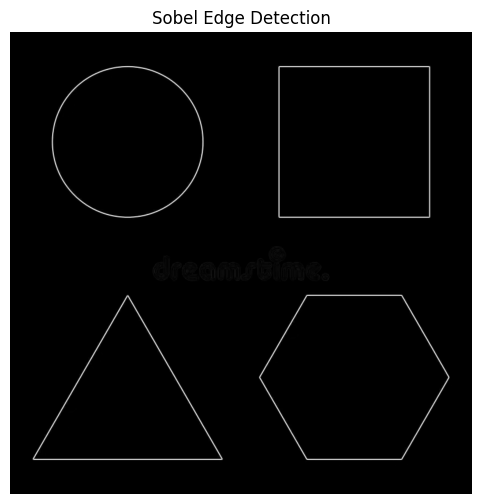

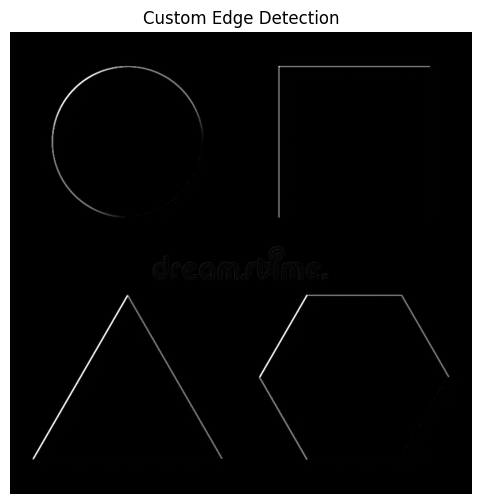

In [5]:
# Sobel (built-in)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobelx, sobely)
show_image(sobel_combined, "Sobel Edge Detection", cmap='gray')

# Custom Prewitt-like edge detection
kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
edge_x = cv2.filter2D(gray, -1, kernelx)
edge_y = cv2.filter2D(gray, -1, kernely)
edge_combined = cv2.addWeighted(edge_x, 0.5, edge_y, 0.5, 0)
show_image(edge_combined, "Custom Edge Detection", cmap='gray')

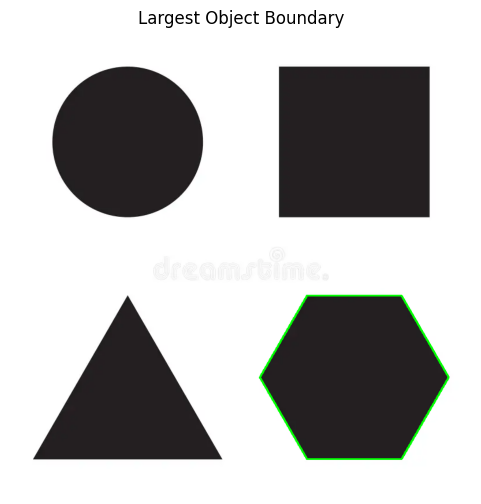

In [11]:
# BOUNDARY OF LARGEST OBJECT
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
largest_contour = max(contours, key=cv2.contourArea)

img_largest = img.copy()
cv2.drawContours(img_largest, [largest_contour], -1, (0, 255, 0), 2)
show_image(img_largest, "Largest Object Boundary")

In [9]:
# CHAIN CODE (4-DIRECTIONAL)
def get_chain_code(contour):
    direction_map = {
        (1, 0): 0,  # Right
        (0, 1): 1,  # Down
        (-1, 0): 2, # Left
        (0, -1): 3  # Up
    }
    chain_code = []
    contour = contour.squeeze()

    for i in range(1, len(contour)):
        dx = contour[i][0] - contour[i - 1][0]
        dy = contour[i][1] - contour[i - 1][1]
        if (dx, dy) in direction_map:
            chain_code.append(direction_map[(dx, dy)])

    return chain_code

chain_code = get_chain_code(largest_contour)
print("4-Directional Chain Code (first 30):", chain_code[:30])

4-Directional Chain Code (first 30): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [12]:
# SHAPE DESCRIPTORS

area = cv2.contourArea(largest_contour)
perimeter = cv2.arcLength(largest_contour, True)
x, y, w, h = cv2.boundingRect(largest_contour)
aspect_ratio = float(w) / h
extent = float(area) / (w * h)
circularity = 4 * np.pi * area / (perimeter ** 2)

print(f"\n--- Shape Descriptors ---")
print(f"Aspect Ratio: {aspect_ratio:.2f}")
print(f"Extent: {extent:.2f}")
print(f"Circularity: {circularity:.2f}")



--- Shape Descriptors ---
Aspect Ratio: 1.15
Extent: 0.75
Circularity: 0.83


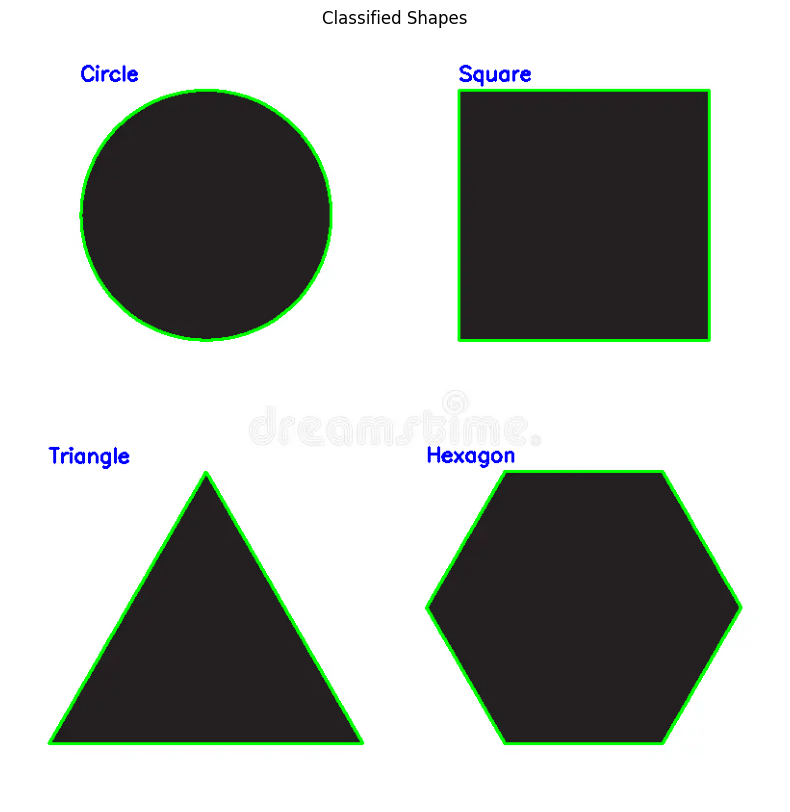

In [14]:
# Threshold the image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

#contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output_img = img.copy()

for contour in contours:
    area = cv2.contourArea(contour)
    if area < 100:  # filter out tiny noise
        continue

    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    vertices = len(approx)

    x, y, w, h = cv2.boundingRect(approx)
    aspect_ratio = float(w) / h
    circularity = 4 * np.pi * area / (perimeter ** 2)

    # SHAPE CLASSIFICATION
    if vertices == 3:
        shape = "Triangle"
    elif vertices == 4:
        shape = "Square" if 0.95 < aspect_ratio < 1.05 else "Rectangle"
    elif vertices == 6:
        shape = "Hexagon"
    elif vertices > 6:
        shape = "Circle" if circularity > 0.8 else "Irregular"
    else:
        shape = "Unidentified"

    #contour and label
    cv2.drawContours(output_img, [contour], -1, (0, 255, 0), 2)
    cv2.putText(output_img, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

# Show final result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Classified Shapes")
plt.axis('off')
plt.show()